# Adversarial Training

__Objective__: Mitigate the model with **targeted attacks** using **Cleverhans** attack library.

__Workflow__:
1.  Load the `Traffic Sign` dataset and examine its structure.
    - Download `tsrd-train` from http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html.
    - Take a closer look at the data inspecting it's size, shape, and quantity.
    - View some random samples using either OpenCV or Matplotlib (or others) of the handwritten digits and observe the complexity of the images. Do you have any issues identify these written numbers?
2. Using `numpy` or other libraries prepare your dataset for training
    - Ensure the format or shape of the data is appropriate for input into your model (one-hot-encoding is needed for the labels)
    - Ensure data types are correct and that data is normalized. 
3. Load and convert the model that is trained in the previous project
   - load using Keras' `load_model` method
   - convert it to logit model using `tf.keras.Model` with `model.input` as the input parameter and `model.layers[-1].output` as the output parameter.
4. Generate malicious inputs
   - FGSM attack
      - Generate malicious inputs based on X_train and FGSM attack using CleverHans' `fast_gradient_method` class with 0.08 epsilon value
5. Adversarial training
   - Create a loop. In each iteration; 
      - generate new malicious inputs for the DL model.
      - Merge the generated malicious with the training dataset
      - Retraind the model using `model.fit` method with the new training dataset
   - Save the new defended model
6. Select first 8 images from test dataset, Plot random 24 images (e.g. 3 rows and 8 columns).
   - First row shows the original images with the predicted labels
   - Second row shows the FGSM based manipulated images with the predicted labels
   - Third row shows the `random uniform` manipulated images with the predicted labels
7. Generate malicious inputs based on X_train and FGSM attack using CleverHans' `fast_gradient_method` class with 0.08 epsilon value with target class `16`

__Deliverable__:

The deliverable is a Jupyter Notebook documenting your workflow. You should save `trainX,testX,trainY,testY,predictions,x_test_adv_fgsm,y_test_adv_fgsm,y_adv_pred_fgsm_hat` numpy matrices as you'll need it for further analysis in the second milestone.

In [1]:
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

from keras.models import load_model
from art.estimators.classification import KerasClassifier
import tensorflow as tf
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import cv2
import os
from keras.preprocessing.image import  img_to_array
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(10)

In [2]:
# Step 1
IMAGE_PATH_TRAIN = '/Users/ozgur/Downloads/tsrd-train/'
COL_NAMES = ['filename','f1','f2','x1','y1','x2','y2','label']
IMAGE_SIZE = (134,128)
EPOCHS = 30
BS = 100
MODEL_NAME = 'cnn-traffic-sign.h5'

In [3]:
# Step 2
df = pd.read_csv('TsignRecgTrain4170Annotation.txt',names=COL_NAMES,sep=';', index_col=False)

files = glob(IMAGE_PATH_TRAIN + '*.png')
data = []
labels = []

for fname in tqdm(range(len(files)),):
    fname = files[fname]
    image = cv2.imread(fname)
    image = cv2.resize(image, IMAGE_SIZE)
    image = img_to_array(image)
    data.append(image)
    
    label = df.query("filename=='" + os.path.split(fname)[1] + "'").label.values[0]
    labels.append(label)
    
data = np.array(data) / 255.0
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

  0%|          | 0/4170 [00:00<?, ?it/s]

In [4]:
# Step 3
model = load_model(MODEL_NAME)
# Create the logit model from tf.keras.Model
logits_model = tf.keras.Model(model.input, model.layers[-1].output)

In [5]:
predictions = model.predict(testX)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(testY, axis=1)) / len(testY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 99.28057553956835%


## 1 Attack results on undefended DL model

In [6]:
# Step 4: Generate adversarial test examples with **targeted Projected Gradient Descent** attack
ATTACK_POWER = 0.1
NUM_OF_MALICIOUS_INPUTS = 150
TARGET_CLASS = 15

randIdx = np.random.randint(0,testX.shape[0],NUM_OF_MALICIOUS_INPUTS)

y_attack_target = (np.ones((NUM_OF_MALICIOUS_INPUTS,)) * TARGET_CLASS).astype(int)

x_test_adv_pgd = projected_gradient_descent(logits_model, testX[randIdx,:],
                                            eps=ATTACK_POWER, norm=np.inf, nb_iter=400, 
                                            eps_iter=ATTACK_POWER/10.0, targeted=True,
                                            y=y_attack_target)

### Initial attack success ratio
Here, we will evaluate the **undefended** DL model for the PGD based malicious inputs.

In [7]:
# Evaluate the the classifier on adversarial test examples
y_adv_pred_pgd = model.predict(x_test_adv_pgd)
attack_success_ratio = np.sum(np.argmax(y_adv_pred_pgd, axis=1) == TARGET_CLASS) / NUM_OF_MALICIOUS_INPUTS
print("Attack success ratio on first {} adversarial test samples: {}%".format(NUM_OF_MALICIOUS_INPUTS, attack_success_ratio*100))

Attack success ratio on first 150 adversarial test samples: 40.666666666666664%


## 2 Adversarial Training
We will try to defen the DL model for PGD based malicious inputs with target class 15. The number of iteration is 10.

In [8]:
# Step 5: Adversarial training
NUM_OF_RETRAIN_ITER = 10

y_test_adv_pgd = testY[randIdx,:]

es = EarlyStopping(monitor='val_loss', 
                   patience=5, 
                   min_delta=0.001,
                   verbose=1,
                   restore_best_weights=True,
                   mode='min')

for i in tqdm(range(NUM_OF_RETRAIN_ITER)):
    logits_model = tf.keras.Model(model.input, model.layers[-1].output)
    x_test_adv_pgd = projected_gradient_descent(logits_model, testX[randIdx,:],
                                                eps=ATTACK_POWER, norm=np.inf, nb_iter=100, 
                                                eps_iter=ATTACK_POWER/10.0, targeted=True,
                                                y=y_attack_target)
    
    x_train_tmp = np.concatenate((trainX, x_test_adv_pgd), axis=0)
    y_train_tmp = np.concatenate((trainY, y_test_adv_pgd), axis=0)
    
    model.fit(x_train_tmp, y_train_tmp, epochs=100,verbose=0,callbacks=[es],
              validation_data=(x_test_adv_pgd, y_test_adv_pgd), batch_size=1000)
model.save('cnn-traffic-sign-defended-for-pgd.h5')

  0%|          | 0/10 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping


### Attack success ratio on Defended model
Now, we will evaluate the **defended** DL model for the PGD based malicious inputs. The result would be lower than attack success ratio on **undefended** DL model.

In [9]:
# Evaluate the the classifier on adversarial test examples
x_test_adv_pgd = projected_gradient_descent(logits_model, testX[randIdx,:],
                                            eps=ATTACK_POWER, norm=np.inf, nb_iter=100, 
                                            eps_iter=ATTACK_POWER/10.0, targeted=True,
                                            y=y_attack_target)
y_adv_pred_pgd = model.predict(x_test_adv_pgd)
attack_success_ratio = np.sum(np.argmax(y_adv_pred_pgd, axis=1) == TARGET_CLASS) / NUM_OF_MALICIOUS_INPUTS
print("Attack success ratio on first {} adversarial test samples: {}%".format(NUM_OF_MALICIOUS_INPUTS, attack_success_ratio*100))

Attack success ratio on first 150 adversarial test samples: 3.3333333333333335%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


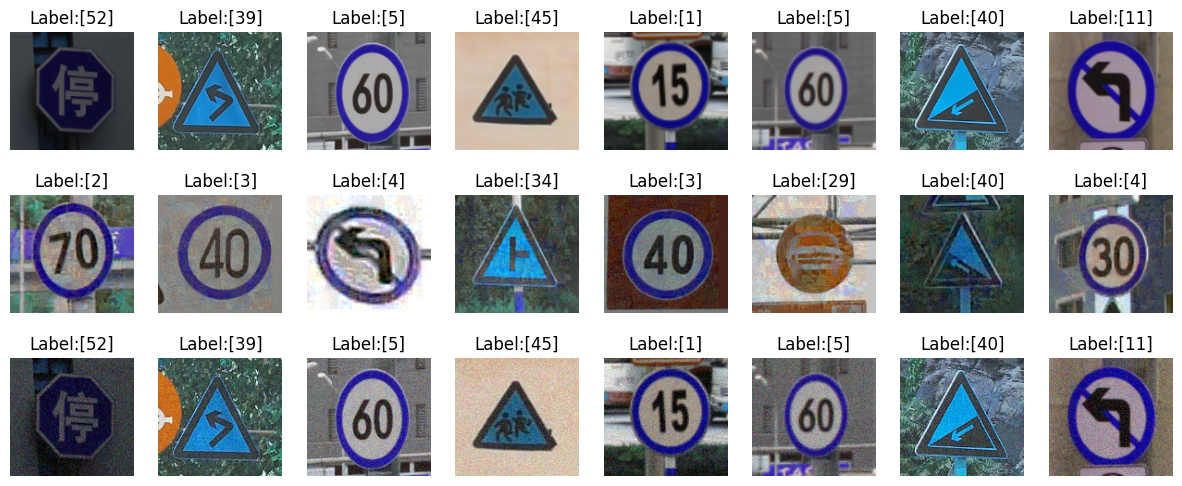

In [10]:
# Step 6: Plot original, noisy and malicious inputs
NUM_OF_ROWS = 3
NUM_OF_COLS = 8
fig, ax = plt.subplots(NUM_OF_ROWS,NUM_OF_COLS, figsize=(15,6))

for i in range(NUM_OF_COLS):
    uniform_noise = np.random.uniform(low=-1.0,high=1.0,size=testX[i].shape) * ATTACK_POWER
    noise = testX[i:i+1] + uniform_noise
    
    benign_pred = model.predict(testX[i:i+1])
    malicious_pred = model.predict(x_test_adv_pgd[i:i+1])
    noise_pred = model.predict(noise)

    ax[0,i].imshow(testX[i])
    ax[1,i].imshow(x_test_adv_pgd[i])
    ax[2,i].imshow(noise[0].clip(0.0,1.0))

    ax[0,i].set_title('Label:' + str(benign_pred.argmax(axis=1)))
    ax[1,i].set_title('Label:' + str(malicious_pred.argmax(axis=1)))
    ax[2,i].set_title('Label:' + str(noise_pred.argmax(axis=1)))
    ax[0,i].axis('off')
    ax[1,i].axis('off')
    ax[2,i].axis('off')
plt.show()

### Attack success ratio on Defended model with another target
Now, we will evaluate the **defended** DL model for the PGD based malicious inputs for another target class (e.g. 16). The result would be higher than attack success ratio on **previous** target class. To protect the DL model for other target class based attacks, you need to perform adversarial training for the other class also.

In [13]:
# Step 7: Attack success ratio on Defended model with another target
NEW_TARGET_CLASS = 16
y_attack_target_new = (np.ones((NUM_OF_MALICIOUS_INPUTS,)) * NEW_TARGET_CLASS).astype(int)

x_test_adv_pgd = projected_gradient_descent(logits_model, testX[randIdx,:],
                                            eps=ATTACK_POWER, norm=np.inf, nb_iter=100, 
                                            eps_iter=ATTACK_POWER/10.0, targeted=True,
                                            y=y_attack_target_new)

y_adv_pred_pgd = model.predict(x_test_adv_pgd)
attack_success_ratio = np.sum(np.argmax(y_adv_pred_pgd, axis=1) == NEW_TARGET_CLASS) / NUM_OF_MALICIOUS_INPUTS
print("Attack success ratio on first {} adversarial test samples: {}%".format(NUM_OF_MALICIOUS_INPUTS, attack_success_ratio*100))

Attack success ratio on first 150 adversarial test samples: 10.0%


In [14]:
# Save matrices
np.savez('milestone-4-1.npz', trainX=trainX, testX=testX,
         trainY=trainY, testY=testY, predictions=predictions,
         x_test_adv_pgd=x_test_adv_pgd,
         y_test_adv_pgd=y_test_adv_pgd)